<a href="https://colab.research.google.com/github/piziomo/Trainings/blob/main/Image_Classification_With_Single_and_Multi_Layer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feeling for the (Neural) Organism (3rd December 2024) Notebook (v.2.2)
IM952 Big Data Research: Hype or Revolution?
3rd December 2024

Michael Castelle, Centre for Interdisciplinary Methodologies, University of Warwick (*M.Castelle.1 at warwick.ac.uk*)

---

## Part 1. Single-Layer Perceptron and Multi-Layer Perceptron

---

In this section, we will be  **classifying grayscale images of handwritten digits** (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s.

The MNIST dataset comes pre-loaded in the Keras deep learning library for Python, in the form of a set of four Numpy arrays.


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input

# Check version of imported modules
print(f"tensorflow version: {tf.__version__}\n",
      f"matplotlib version: {matplotlib.__version__}\n",
      f"numpy version: {np.__version__}")

tensorflow version: 2.17.1
 matplotlib version: 3.8.0
 numpy version: 1.26.4


### Load dataset

`train_images` and `train_labels` form the "training set", the data that the model will learn from. The model will then be tested on the "test set", `test_images` and `test_labels`. The images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print("train_images.shape:", train_images.shape)
print("train_labels.shape:", train_labels.shape)
print("test_images.shape:", test_images.shape)
print("test_labels.shape:", test_labels.shape)

train_images.shape: (60000, 28, 28)
train_labels.shape: (60000,)
test_images.shape: (10000, 28, 28)
test_labels.shape: (10000,)


In [ ]:
print(train_labels[0:10])

[5 0 4 1 9 2 1 3 1 4]


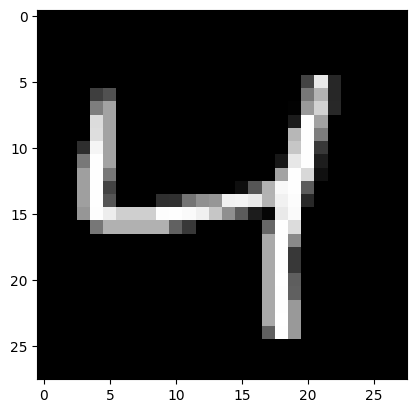

label for image:  4


In [ ]:
# pick a sample to plot
sample = 2
image = train_images[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()
print("label for image: ", train_labels[sample])

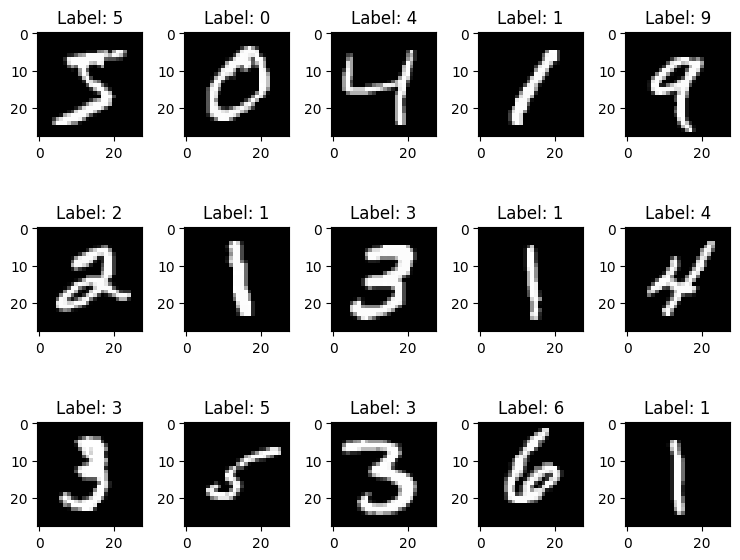

In [ ]:
num = 15
images = train_images[:num]     #select 15 samples with their labels
labels = train_labels[:num]

num_row = 3
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

Let’s explore the test data.

In [ ]:
print("test_images.shape:", test_images.shape)
print("test_labels.shape:", test_labels.shape)

test_images.shape: (10000, 28, 28)
test_labels.shape: (10000,)


In [ ]:
# Display number of labels
len(test_labels)

10000

In [ ]:
# Print output class for the selected training samples
test_labels[0:20]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=uint8)

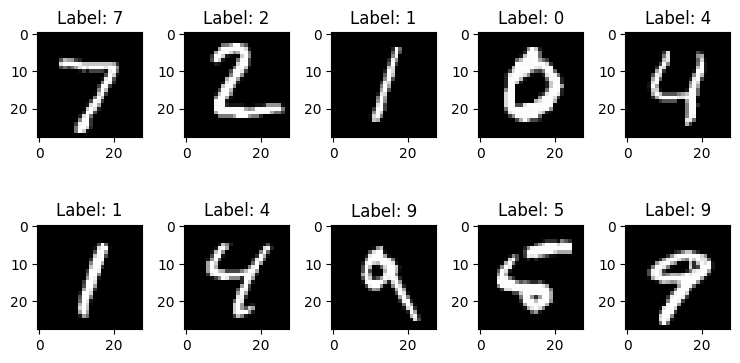

In [ ]:
num = 10
images = test_images[:num]
labels = test_labels[:num]

num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(test_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

### Preprocess data

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval. Previously, our training images for instance were stored in an array of shape (60000, 28, 28) integer values in the [0, 255] interval. We transform it into a floating-point value array of shape (60000, 28 * 28) with values between 0 and 1.

We do also need to categorically encode the labels (so-called "one-hot" encoding).

In [ ]:
train_images_new = train_images.reshape((60000, 28 * 28))
train_images_new = train_images_new.astype('float32') / 255

test_images_new = test_images.reshape((10000, 28 * 28))
test_images_new = test_images_new.astype('float32') / 255

train_labels_new = to_categorical(train_labels)
test_labels_new = to_categorical(test_labels)

In [ ]:
print(train_labels_new[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Build a Single-Layer Perceptron (SLP) model

Here our network consists of a single Dense (or "fully-connected") 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.



In [ ]:
# Single-Layer Perceptron
slp_model = models.Sequential()
slp_model.add(Input(shape=(28*28,)))
slp_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
print(type(slp_model))

<class 'keras.src.models.sequential.Sequential'>


### Compile SLP model

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

 * A loss function: this is how the network will be able to measure how good a job it is doing classifying its training data, and thus how it will be able to steer itself in the right direction with the optimizer (see below).

 * An optimizer: this is the mechanism through which the network will update itself based on the output of the loss function. Geoff Hinton's 'rmsprop' algorithm maintains an average of the squares of the losses and adjusts weights via backpropagation accordingly.

 * Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

In [ ]:
slp_model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
slp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
784*10+10

7850

### Train the SLP model

Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over the training data

In [ ]:
history=slp_model.fit(train_images_new, train_labels_new, epochs=5, batch_size=1024)

Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5083 - loss: 1.7056
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8405 - loss: 0.7310
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.5042
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8913 - loss: 0.4081
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8988 - loss: 0.3710


### Use model to make predictions
Now that we have trained the model, we can use it to predict class probabilities for new digits, i.e., images that weren’t part of the training data, like those from the test set.

In [ ]:
# Make predictions
test_digits = test_images_new[0:10]
predictions = slp_model.predict(test_digits)
np.set_printoptions(suppress=True, linewidth=200)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
[0.00014571 0.00000048 0.0001305  0.00244384 0.00005124 0.00013324 0.00000195 0.99356246 0.00022586 0.00330475]


Each number of index i in that array corresponds to the probability that digit image test_digits[0] belongs to class i.  This  first  test  digit  has  the  highest  probability  score  (0.99+,  almost  1)  at index 7, so according to our model, it must be a 7. Let's check this out:

In [ ]:
print(predictions[0][7])
print(predictions[0].argmax())

0.99356246
7


Check that the test label agrees:

In [ ]:
test_labels[0]

7

### Evaluation of SLP model

In [ ]:
test_loss, test_acc = slp_model.evaluate(test_images_new, test_labels_new)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8935 - loss: 0.3834


In [ ]:
print('test_acc:', test_acc)

test_acc: 0.9075000286102295


### Plot training loss and training accuracy

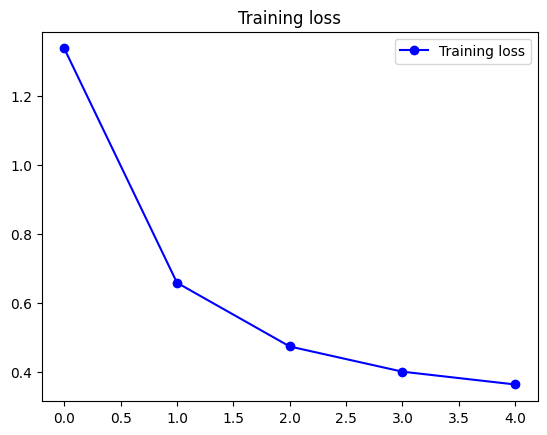

<Figure size 640x480 with 0 Axes>

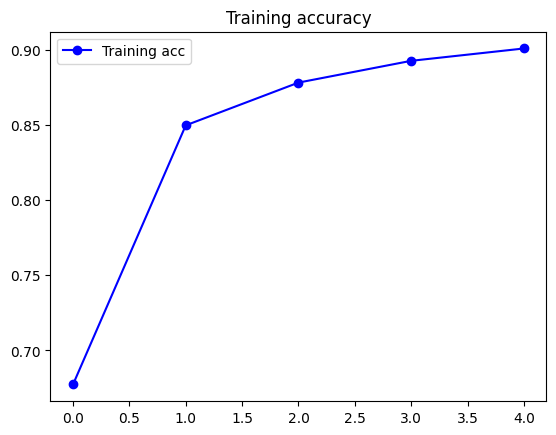

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, loss, '-bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, '-bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

### Display some of the wrong guesses for single-layer perceptron

Now let's look for some mis-classified digits.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


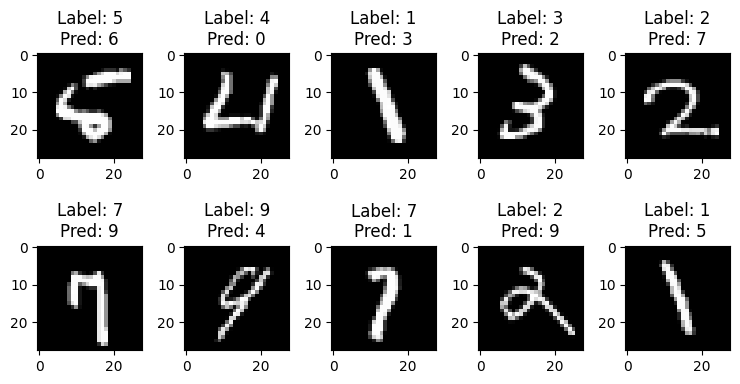

In [ ]:
predictions = slp_model.predict(test_images_new)
final_predictions = np.argmax(predictions, axis=1)
(incorrects,) = np.nonzero(final_predictions != test_labels)
num = 10
incorrect_indices = incorrects[0:num]
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    incorrect_index = incorrect_indices[i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(test_images[incorrect_index], cmap='gray')
    ax.set_title('Label: {}\nPred: {}'.format(*[test_labels[incorrect_index], final_predictions[incorrect_index]]))
plt.tight_layout()
plt.show()

### Build a Multi-Layer Perceptron (MLP) model

Here our network consists of a sequence of two Dense ("fully-connected") layers. The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each score will be the probability that the current digit image belongs to one of our 10 digit classes.


In [ ]:
mlp_model = models.Sequential()
mlp_model.add(Input(shape=(28*28,)))
mlp_model.add(layers.Dense(512, activation='relu'))
mlp_model.add(layers.Dense(10, activation='softmax'))

### Compile the MLP model

In [ ]:
mlp_model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [ ]:
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(784*512 + 512)
print(512*10 + 10)
print((784*512+512) + (512*10+10))

401920
5130
407050


### Train the MLP model


In [ ]:
history = mlp_model.fit(train_images_new, train_labels_new, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8716 - loss: 0.4372
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.1132
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9774 - loss: 0.0734
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9851 - loss: 0.0511
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9883 - loss: 0.0372


### Evaluation of MLP model

In [ ]:
test_loss, test_acc = mlp_model.evaluate(test_images_new, test_labels_new)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9755 - loss: 0.0779


In [ ]:
print('test_acc:', test_acc)

test_acc: 0.979200005531311


The test set accuracy turns out to around *97.8%* -- that's a fair bit lower than the training set accuracy. This gap between training accuracy and test accuracy is an example of "overfitting", a situation in which machine learning models perform worse on new data than on their training data.

### Plot training loss and training accuracy

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, loss, '-bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, '-bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

### Display some of the wrong guesses for multi-layer perceptron

Now let's look for some mis-classified digits.



In [ ]:
predictions = mlp_model.predict(test_images_new)
final_predictions = np.argmax(predictions, axis=1)
(incorrects,) = np.nonzero(final_predictions != test_labels)
num = 10
incorrect_indices = incorrects[0:num]
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    incorrect_index = incorrect_indices[i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(test_images[incorrect_index], cmap='gray')
    ax.set_title('Label: {}\nPred: {}'.format(*[test_labels[incorrect_index], final_predictions[incorrect_index]]))
plt.tight_layout()
plt.show()

---

## Part 2. Convolutional Neural Network

---

### Build the network

A basic convnet will be used: a stack of `Conv2D` and `MaxPooling2D` layers.
Importantly, a CNN takes as input tensors of shape (`image_height, image_width, image_channels`), not including the batch dimensions. In this case, we have to configure the CNN to process images of a size compatible with the MNIST database, so it will be of size (28, 28, 1). This will be the input shape to pass to the first layer.

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(Input(shape=(28, 28, 1)))
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn_model.summary()

In [ ]:
print(3*3*32 + 32)
print((3*3*32) * 64 + 64)
print((3*3*64) * 64 + 64)
print((3*3*32 + 32) + ((3*3*32) * 64 + 64) + ((3*3*64) * 64 + 64))

The output of every `Conv2D` and `MaxPooling2D` layer is also a tensor of shape (`height, width, channels`). Note how the image dimensions tend to shrink as going deeper in the network.

While the the 3rd parameter of the input shape indicates the color channels, in the output of a layer it indicates the number of filters (features) over its input. So, every dimension in the depth axis is a feature (filter), and the 2D tensor is a 2D spatial map of the response of this filter over the input.

#### Insert a classifier on top of the CNN

This is a classification problem, so we need to put the last output tensor of the CNN as input to a densely connected network, similar to the one in the SLP/MLP example. We have a class of 10 categories, so the solution will be a 10-way classification, using a final layer of 10 outputs and a `softmax` activation.

In [ ]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.summary()

Note that the `Flatten` layer takes as its input a vector of shape (`3 * 3 * 64`), which is the output of the last `Conv2D` layer.

In [ ]:
print((3*3*64)*64 + 64)
print(64*10 + 10)

In [ ]:
cnn_train_images = train_images.reshape((60000, 28, 28, 1))
cnn_train_images = train_images.astype('float32') / 255
cnn_test_images = test_images.reshape((10000, 28, 28, 1))
cnn_test_images = test_images.astype('float32') / 255

### Train the Convolutional Neural Network (CNN) model

In [ ]:
cnn_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = cnn_model.fit(cnn_train_images, train_labels_new, epochs=5, batch_size=64)

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, loss, '-bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, '-bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

### Evaluate the accuracy of the CNN Model

In [ ]:
test_loss, test_acc = cnn_model.evaluate(cnn_test_images, test_labels_new)

In [ ]:
print('test_acc:', test_acc)

### Look at some failed predictions by the CNN model

In [ ]:
predictions = cnn_model.predict(cnn_test_images)
final_predictions = np.argmax(predictions, axis=1)
(incorrects,) = np.nonzero(final_predictions != test_labels)
num = 10
incorrect_indices = incorrects[0:num]
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    incorrect_index = incorrect_indices[i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(test_images[incorrect_index], cmap='gray')
    ax.set_title('Label: {}\nPred: {}'.format(*[test_labels[incorrect_index], final_predictions[incorrect_index]]))
plt.tight_layout()
plt.show()

# Bonus Section: GPT-2 Exploration

In [ ]:
!pip install transformers

In [ ]:
#for reproducibility
SEED = 34

#maximum number of words in output text
MAX_LEN = 70

def wrap_print(text, width=80):
    for i in range(0, len(text), width):
        print(text[i:i+width], end='\n')

import builtins
print = builtins.print

In [ ]:
import torch
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

#get large GPT2 tokenizer and GPT2 model
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
#GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2-large", pad_token_id=tokenizer.eos_token_id)

#tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
#GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2-medium", pad_token_id=tokenizer.eos_token_id)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
GPT2 = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

#view model parameters
GPT2.summary()

In [ ]:
for variable in GPT2.trainable_variables:
    print(variable.name, variable.shape)

In [ ]:
import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
input_sequence = "I don't know about you, but after this long day of work, "

In [ ]:
# See how many subwords we have
vocab_size = tokenizer.vocab_size

print("vocab size:", vocab_size)

# Tokenize the input sequence
tokens = tokenizer.tokenize(input_sequence)

# fix the spaces in the tokenized output for viewing purposes
tokens_with_spaces = [token.replace('Ġ', ' ') for token in tokens]

# Print the subword tokens
print("tokens:", tokens_with_spaces)

# Convert tokens to input IDs
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Print the input IDs
print("input_ids:", input_ids, type(input_ids))

In [ ]:
# Get the initial embeddings from the GPT-2 model
input_embeddings = GPT2.get_input_embeddings()

# See the initial embedding vector for the first subword in the input, i.e. the word "I" (token #40 in the GPT-2 vocabulary)
input_embedding_40 = input_embeddings(40)

print(input_embedding_40.shape)

# Print out the first 32 elements of the 768-element vector
print(input_embedding_40[0:32])

In [ ]:
# encode the sequence of input tokens
input_ids = tokenizer.encode(input_sequence, return_tensors='tf')

# generate text until the output length reaches 50 tokens
greedy_output = GPT2.generate(input_ids, max_length = MAX_LEN)

print("Output:\n" + 100 * '-')
wrap_print(tokenizer.decode(greedy_output[0], skip_special_tokens = True))

In [ ]:
# use temperature to increase the likelihood of low-"probability" candidates being
sample_output = GPT2.generate(
                             input_ids,
                             do_sample = True,
                             max_length = MAX_LEN,
                             top_k = 0,
                             temperature = 0.6
)

print("Output:\n" + 100 * '-')
wrap_print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

In [ ]:
def wrap_print(text, width=80):
    for i in range(0, len(text), width):
        print(text[i:i+width], end='\n')


# use temperature to increase the likelihood of low-"probability" candidates being
sample_output = GPT2.generate(
                             input_ids,
                             do_sample = True,
                             max_length = MAX_LEN,
                             top_k = 0,
                             temperature = 1.0
)

print("Output:\n" + 100 * '-')
wrap_print(tokenizer.decode(sample_output[0], skip_special_tokens = True))

In [ ]:
# sample from only 5 most likely words at each generation step
sample_output = GPT2.generate(
                             input_ids,
                             do_sample = True,
                             max_length = MAX_LEN,
                             top_k = 5
)

print("Output:\n" + 100 * '-')
wrap_print(tokenizer.decode(sample_output[0], skip_special_tokens = True), '...')

In [ ]:
# sample only from 40% most likely words at each generation step
sample_output = GPT2.generate(
                             input_ids,
                             do_sample = True,
                             max_length = MAX_LEN,
                             top_p = 0.40,
                             top_k = 0
)

print("Output:\n" + 100 * '-')
wrap_print(tokenizer.decode(sample_output[0], skip_special_tokens = True), '...')

In [ ]:
# combine both sampling techniques
sample_outputs = GPT2.generate(
                              input_ids,
                              do_sample = True,
                              max_length = 2*MAX_LEN,                              # to test how long we can generate and have it be coherent
                              temperature = .75,
                              top_k = 50,
                              top_p = 0.85,
                              num_return_sequences = 5
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    curr_str = "{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True))
    wrap_print(curr_str)
    print('')

In [ ]:
prompt1 = 'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.'

input_ids = tokenizer.encode(prompt1, return_tensors='tf')

In [ ]:
from IPython.display import display, HTML

MAX_LEN=1000

sample_outputs = GPT2.generate(
                              input_ids,
                              do_sample = True,
                              max_length = MAX_LEN,
                              #temperature = .8,
                              top_k = 50,
                              top_p = 0.85
                              #num_return_sequences = 5
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    curr_str = "{}: {}...".format(i, tokenizer.decode(sample_output, skip_special_tokens = True))
    wrap_print(curr_str)
    print('')